# Sentiment Analysis with the imdb dataset

Run this notebook to explore [RNN](https://en.wikipedia.org/wiki/Recurrent_neural_network) models that performs a binary classification using the film reviews contained in the imdb dataset

In [1]:
# Notebook should be run with tensorflow 2.0.0
import tensorflow as tf
# Check tf version
print(tf.__version__)

2.0.0


In [3]:
# Load the the imdb data set
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

# you may find troubles at first, if so uncomment the line below and run again
!pip install -q tensorflow-datasets

In [4]:
# Notice that data is stored as a dictionary
imdb

{'test': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>,
 'train': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>,
 'unsupervised': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>}

In [5]:
# Get basic information about this dataset
info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
      title     = {Learning Word

**more information about the data set:
https://github.com/tensorflow/datasets/blob/master/docs/catalog/imdb_reviews.md**    

In [6]:
# Data is already split for training/test
train_data, test_data = imdb['train'], imdb['test']

# let's see some of the content of this data by printing one batch with 3 examples
train_example= imdb['train'].batch(1).take(3)
for data in train_example:
    print(data)
    print('')

(<tf.Tensor: id=203, shape=(1,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."],
      dtype=object)>, <tf.Tensor: id=204, shape=(1,), dtype=int64, numpy=array([0], dtype=int64)>)

(<tf.Tensor: id=205, shape=(1,), dtype=string, numpy=
array([b'I have been known to fall asleep during films, but this is us

In [7]:
# We need to keep the sentences and labels in a list/array
import numpy as np

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

for s,l in train_data:
    training_sentences.append(str(s.numpy()))
    training_labels.append(l.numpy())

for s,l in test_data:
    testing_sentences.append(str(s.numpy()))
    testing_labels.append(l.numpy())

testing_labels_final = np.array(testing_labels)
training_labels_final = np.array(training_labels)

In [8]:
# let's check the labeled data 
print('Training review example: '+'\n')
print(training_sentences[0],'\n')
print('label: ',training_labels_final[0],'\n')
print('Test review example: '+'\n')
print(testing_sentences[0],'\n')
print('label: ',testing_labels_final[0])

Training review example: 

b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it." 

label:  0 

Test review example: 

b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawles

In [9]:
# For convenience, we define the hyperparameters of the model here
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
oov_tok = "<OOV>"

In [10]:
#----- Data preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# tokenize the data.
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
# convert into sequence of indices.
sequences = tokenizer.texts_to_sequences(training_sentences)
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
# pad the sequences such that all the sentences are of equal length when feeding into the model.
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

In [11]:
# Define a model with LSTM 
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                12544     
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 172,941
Trainable params: 172,941
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Train the model
num_epochs = 15
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Train on 25000 samples, validate on 25000 samples
Epoch 1/15
25000/25000 [==============================] - 55s 2ms/sample - loss: 0.4842 - accuracy: 0.7592 - val_loss: 0.3755 - val_accuracy: 0.8327
Epoch 2/15
25000/25000 [==============================] - 51s 2ms/sample - loss: 0.3096 - accuracy: 0.8748 - val_loss: 0.3989 - val_accuracy: 0.8268
Epoch 3/15
25000/25000 [==============================] - 51s 2ms/sample - loss: 0.2447 - accuracy: 0.9039 - val_loss: 0.4697 - val_accuracy: 0.8181
Epoch 4/15
25000/25000 [==============================] - 49s 2ms/sample - loss: 0.2012 - accuracy: 0.9240 - val_loss: 0.5373 - val_accuracy: 0.8093
Epoch 5/15
25000/25000 [==============================] - 49s 2ms/sample - loss: 0.1727 - accuracy: 0.9337 - val_loss: 0.5948 - val_accuracy: 0.8083
Epoch 6/15
25000/25000 [==============================] - 52s 2ms/sample - loss: 0.1503 - accuracy: 0.9427 - val_loss: 0.6456 - val_accuracy: 0.8082
Epoch 7/15
25000/25000 [==============================] 

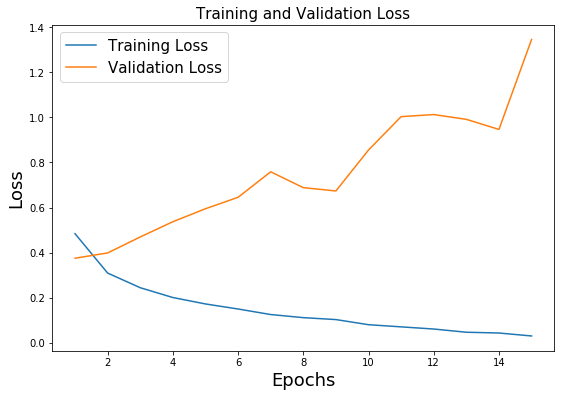

In [13]:
# Let's plot the loss
import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']


fig,ax=plt.subplots(figsize=(9,6))
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=15)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(fontsize=15)
plt.show();

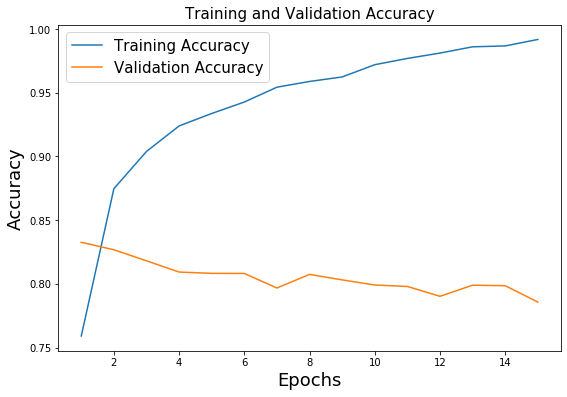

In [14]:
# Plot Accuracy
fig,ax=plt.subplots(figsize=(9,6))
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy', fontsize=15)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.legend(fontsize=15)
plt.show();

In [15]:
# Model above shows overfitting, yet how good is at predicting?

new_reviews = [
    'This movie is the best. Really liked it.',
    'Bad movie, I even fell asleep!',
    'I think this is the worst movie of all time.',
    'This movie is so hilarious. I want to watch it again!'
              ]

new_seq = tokenizer.texts_to_sequences(new_reviews)
padded=pad_sequences(new_seq, maxlen=max_length,truncating=trunc_type)
output=model.predict(padded)

for i in range(0,len(new_reviews)):
    print('Review: '+new_reviews[i]+' '+', Sentiment:'+str(output[i][0])+'\n' )
    if output[i]> 0.5:
        print(' :) '+'\n')
    else:
        print(' :( '+'\n')

Review: This movie is the best. Really liked it. , Sentiment:0.9990953

 :) 

Review: Bad movie, I even fell asleep! , Sentiment:0.007370938

 :( 

Review: I think this is the worst movie of all time. , Sentiment:0.0023363226

 :( 

Review: This movie is so hilarious. I want to watch it again! , Sentiment:0.9718777

 :) 



Not that bad after all!

**Try it yourself:**

Below there are other two simple models that can be trained.

Uncomment the cell below to compile other models and write your own review to test how well does the model perform.

In [ ]:
"""
# Model With Gated Recurrent Unit Network:
model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

# Model With Convolutional Neural Network
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model2.summary())

# After training some of the models above you can write a review to test it
new_reviews = [
    'WRITE YOUR OWN REVIEW HERE'
              ]

"""